In [136]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sbn
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import re

#import bokeh.palettes

plt.rcParams['svg.fonttype'] = 'none'

sns.set_context("paper")
sns.set_style("white")

In [2]:
data_dir = "../Data/Growth_data/evolved-isolate-growth-data/"
exp_list = {
    'ALE_1,2-propanediol_duplicates_121514': "1,2-propanediol",
    'ALE_2,3-butanediol_duplicates_122414': "2,3-butanediol",
    'ALE_adipate_duplicates_091014': "adipate",
    'ALE_butanol_duplicates_060514': "butanol",
    'ALE_coumarate_duplicates_061914': "coumarate",
    'ALE_glutarate_duplicates_060214': "glutarate",
    'ALE_HDMA_duplicates_080114': "HMDA",
    'ALE_hexanoate_duplicates_101314': "hexanoate",
    'ALE_isobutyrate_duplicates_091114': "isobutyrate",
    'ALE_octanoate_duplicates_122214': "octanoate",
    'ALE_putrescine_duplicates_073014': "putrescine",
}

In [5]:
layouts = {}
for exp, comp in exp_list.items():
    date = exp.split("_")[-1]
    excel_name = exp + ".xls"
    layouts[exp] = {}
    workbook = xlrd.open_workbook(data_dir + "raw Biolector data/" + excel_name)
    sheet = workbook.sheet_by_name("subtracted")
    for well, strain in zip(sheet.col_slice(0), sheet.col_slice(2)):
        well, strain = well.value, strain.value
        if well == "":
            continue
        layouts[exp][well] = strain

In [6]:
# Compile growth curves
for exp in exp_list:
    growth_data = pd.read_csv(data_dir + "/output/" + exp + ".v2.tsv", sep="\t", index_col=0)
    for well in list(growth_data):
        ser = growth_data[well]
        if well in layouts[exp]:
            strain = layouts[exp][well]
            growth_data[strain] = ser
        del growth_data[well]
    growth_data.to_csv(data_dir + "/curves/" + exp + ".tsv", sep="\t")

In [143]:
cond = 'HMDA'

In [177]:
def plot_best(cond):
    for i in exp_list:
        if(exp_list.get(i)==cond):
            filename = i
    growth_data = pd.read_csv(data_dir + "/output/" + filename + ".v2.tsv", sep="\t", index_col=0)
    for well in list(growth_data):
        ser = growth_data[well]
        if well in layouts[filename]:
            strain = layouts[filename][well]
            growth_data[strain] = ser
        del growth_data[well]
        
    ale_df = pd.read_csv("../Data/Growth_data/evolved-isolate-growth-data/Evolved_isolates_data_frame.tsv", sep="\t")
    #Search Best strain
    best = ale_df[ale_df.compound == cond].groupby('strain').mean().sort_values(by='growth_rate', ascending=False).index[0]
    print("the best strain in the ", cond, " condition is ",best)

    if(cond =='HMDA'):
        best = best.replace('HMDA','HDMA')
    growth=pd.DataFrame(index=growth_data.index, columns=['MG_avg', 'MG_err', 'best_avg', 'best_err'])

    for i in growth_data.index:
        growth.loc[i,'MG_avg'] = growth_data.loc[i,['MG1655-1','MG1655-2']].mean()
        growth.loc[i,'MG_err'] = abs(growth_data.at[i,'MG1655-1']-growth_data.at[i,'MG1655-2'])
        growth.loc[i,'best_avg'] = growth_data.loc[i,[best+'_1',best+'_2']].mean()
        growth.loc[i,'best_err'] = abs(growth_data.at[i,best+'_1']-growth_data.at[i,best+'_2'])/2

    total_index =growth.index

    for i in range(0, len(total_index)):
        if i%6!=0:
            growth=growth.drop(index = total_index[i])

    strain_list= ['MG', 'best']
    strain_color = {
        'MG':'black',
        'best':'red'
    }

    #Plot figures
    fig, ax1 = plt.subplots(
        dpi=100,
        figsize=(3,3)
    )
    #fig.subplots_adjust(left=0.1)

    for i in strain_list:
        ax1.errorbar(growth.index, growth[i+'_avg'], yerr=growth[i+'_err'],
                     marker='s',
                     capsize=2, 
                     color=strain_color.get(i), 
                     label=i
                    )
    ax1.set_xlim(0,48)
    ax1.set_ylim(0,)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    ax1.set_xlabel("Time", fontsize=15)
    ax1.set_ylabel("Biomass", fontsize=15)
    plt.xticks([0,8,16,24,32,40,48])

    return fig, ax1 


the best strain in the  putrescine  condition is  PUTR3-1


(<Figure size 300x300 with 1 Axes>,
 <AxesSubplot:xlabel='Time', ylabel='Biomass'>)

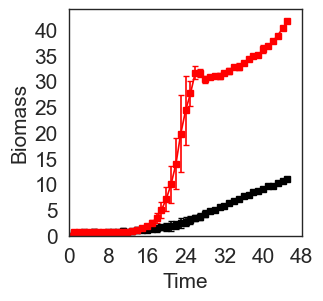

In [178]:
plot_best('putrescine')

In [160]:
exp_list

{'ALE_1,2-propanediol_duplicates_121514': '1,2-propanediol',
 'ALE_2,3-butanediol_duplicates_122414': '2,3-butanediol',
 'ALE_adipate_duplicates_091014': 'adipate',
 'ALE_butanol_duplicates_060514': 'butanol',
 'ALE_coumarate_duplicates_061914': 'coumarate',
 'ALE_glutarate_duplicates_060214': 'glutarate',
 'ALE_HDMA_duplicates_080114': 'HMDA',
 'ALE_hexanoate_duplicates_101314': 'hexanoate',
 'ALE_isobutyrate_duplicates_091114': 'isobutyrate',
 'ALE_octanoate_duplicates_122214': 'octanoate',
 'ALE_putrescine_duplicates_073014': 'putrescine'}

In [164]:
fig

(<Figure size 300x300 with 1 Axes>,
 <AxesSubplot:xlabel='Time', ylabel='Biomass'>)

1,2-propanediol
the best strain in the  1,2-propanediol  condition is  12PD7-6
2,3-butanediol
the best strain in the  2,3-butanediol  condition is  23BD2-4
adipate
the best strain in the  adipate  condition is  ADIP5-2
butanol
the best strain in the  butanol  condition is  BUT3-3
coumarate
the best strain in the  coumarate  condition is  COUM8-6
glutarate
the best strain in the  glutarate  condition is  GLUT5-4
HMDA
the best strain in the  HMDA  condition is  HMDA3-5
hexanoate
the best strain in the  hexanoate  condition is  HEXA4-10
isobutyrate
the best strain in the  isobutyrate  condition is  IBUA6-9
octanoate
the best strain in the  octanoate  condition is  OCTA4-13
putrescine
the best strain in the  putrescine  condition is  PUTR3-1


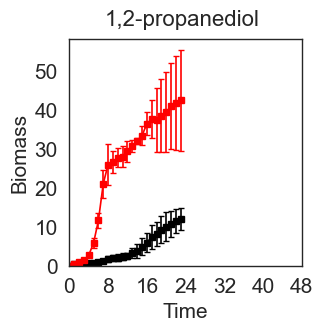

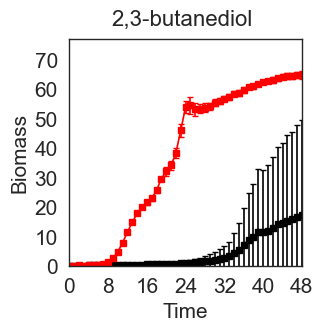

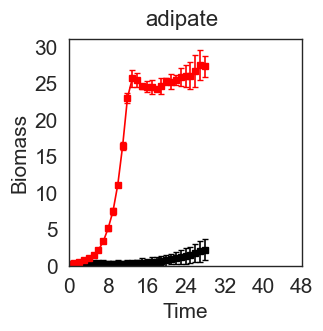

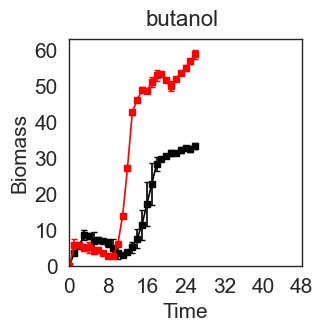

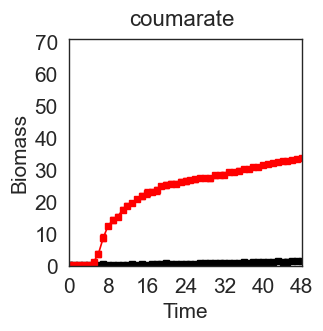

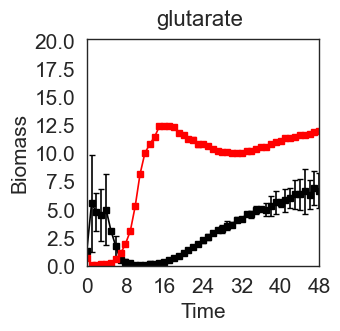

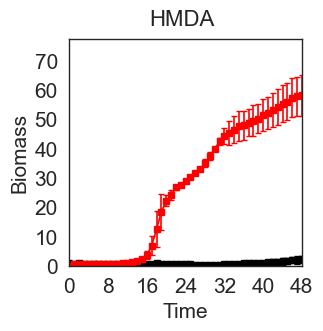

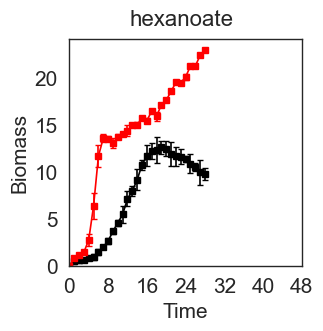

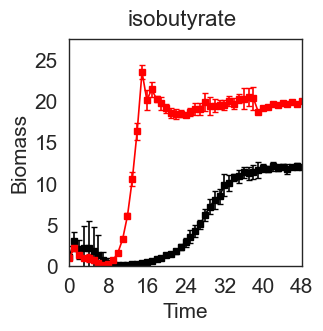

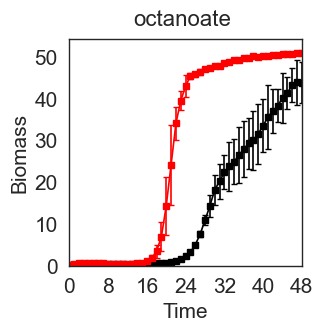

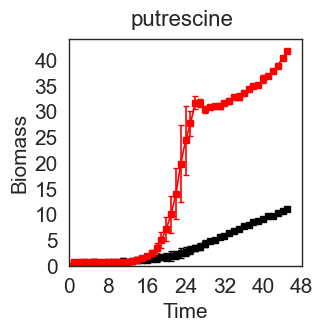

In [179]:
for i in exp_list.values():
    print(i)
    fig, ax = plot_best(i)
    
    fig.suptitle(i, fontsize=16)
    fig.savefig("../../Ecoli_chem_tol_ALE/Plots/"+i+"_best.svg")

In [8]:
growth_data

,MG1655-1,PUTR2-4_1,PUTR2-6_1,PUTR3-1_1,PUTR3-9_1,PUTR3-10_1,PUTR4-3_1,PUTR4-7_1,PUTR4-8_1,PUTR5-1_1,...,PUTR6-10_2,PUTR7-1_2,PUTR7-7_2,PUTR7-9_2,PUTR8-3_2,PUTR8-6_2,PUTR8-10_2,PUTR3-9_3,PUTR3-10_3,PUTR4-3_3
time,,,,,,,,,,,,,,,,,,,,,
0.00486,0.000,0.000,0.133,0.000,0.000,0.000,0.077,0.000,0.000,0.000,...,0.045,0.117,0.043,0.162,0.000,0.000,0.000,0.000,0.000,0.000
0.17143,0.472,0.125,0.152,0.193,0.110,0.216,0.122,0.299,0.037,0.236,...,0.010,0.180,0.402,0.369,0.248,0.722,0.110,0.438,0.274,0.946
0.33820,0.676,0.109,0.088,0.388,0.029,0.209,0.109,0.440,0.011,0.297,...,0.000,0.000,0.178,0.273,0.415,0.827,0.189,0.417,0.415,1.112
0.50481,0.739,0.174,0.000,0.505,0.146,0.505,0.174,0.480,0.100,0.333,...,0.116,0.115,0.141,0.286,0.301,0.686,0.253,0.481,0.583,0.970
0.67155,0.676,0.135,0.088,0.746,0.157,0.413,0.109,0.517,0.037,0.349,...,0.128,0.154,0.076,0.196,0.338,0.827,0.266,0.520,0.722,0.985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44.50923,10.989,30.617,29.421,41.041,44.295,33.768,28.152,33.843,31.594,18.169,...,41.627,45.044,28.318,24.804,33.844,57.513,66.428,25.087,35.983,39.962
44.67590,10.864,31.033,29.916,41.449,43.778,33.548,28.517,33.728,31.690,18.618,...,42.377,45.341,28.524,25.118,33.413,57.696,66.762,25.533,35.286,39.683
44.84257,10.920,30.991,29.375,41.556,43.883,33.769,28.293,33.737,31.304,19.903,...,41.930,44.889,28.405,24.844,32.922,57.417,66.658,25.364,36.295,40.316
